In [189]:
import os
import torch
import pandas as pd
from skimage import io, transform, color
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2

In [190]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""
    """Inspired by PyTorch docs"""
    def __init__(self, root_dir, onlyNose=False, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.only_nose = onlyNose
        self.transform = transform

    def __len__(self):
        return 240

    def __getitem__(self, idx):
        i = (idx // 6) + 1
        j = (idx % 6) + 1
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        views = []
        landmarks = []
        gender = 'm'
        females = [8, 12, 14, 15, 22, 30, 35]
        if i in females:
            gender = 'f'
            
        image = plt.imread(self.root_dir + '{:02d}-{:d}{}.jpg'.format(i,j,gender))
        if self.only_nose:
            image = cv2.resize(image, dsize=(80, 60))
        else:
            image = cv2.resize(image, dsize=(160, 120)) 
        image = color.rgb2gray(image) - 0.5
        
        file = open(self.root_dir + '{:02d}-{:d}{}.asf'.format(i,j,gender))
        points = file.readlines()[16:74]
        landmark = []
        if self.only_nose:
            #for point in points:
            point = points[-6]
            x,y = point.split('\t')[2:4]
            x = float(x)
            y = float(y)
            x *= len(image[0])
            y *= len(image)
            landmark.append([float(x), float(y)])
        else:
            for point in points:
                x,y = point.split('\t')[2:4]
                x = float(x)
                y = float(y)
                x *= len(image[0])
                y *= len(image)
                landmark.append([float(x), float(y)])
        landmark = np.array(landmark)
        landmark = landmark.astype('float').reshape(-1, 2)
        image = np.expand_dims(image, 0)  
        sample = {'image': image, 'landmarks': landmark}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [191]:
def show_landmarks(fig, image, landmarks):
    fig.imshow(np.squeeze(image))
    fig.scatter([x[0] for x in landmarks], [y[1] for y in landmarks], s=10, marker='.', c='r')

In [192]:
class Shift(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        shift = np.random.randint(-10, 10)
        for i in landmarks:
            i[0] += shift
        return {'image': np.roll(image, shift), 'landmarks': landmarks}

In [196]:
faces = FaceLandmarksDataset('./imm_face_db/', True, Shift())
train_ds, valid_ds = [faces[x] for x in range(192)], [faces[x] for x in range(192, 240)]
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=16)
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True, num_workers=16)

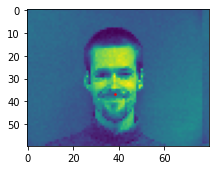

In [202]:
i = next(iter(valid_dl))
fig = plt.figure(figsize=(15,10))
for j in range(1,2):
    ax = fig.add_subplot(1,4,j)
    show_landmarks(ax, i['image'][j-1], i['landmarks'][j-1])


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class NoseNet(nn.Module):

    def __init__(self):
        super(NoseNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.conv2 = nn.Conv2d(12, 24, 5)
        self.conv3 = nn.Conv2d(24, 32, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(768, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = NoseNet()

In [16]:
def train(train_loader, valid_loader, model, criterion, optimizer, fullFace,
          n_epochs=50, saved_model='model.pt'):
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch in train_loader:
            # clear the gradients of all optimized variable
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            if fullFace:
                output = torch.reshape(output, (1,58,2))
            #output = output.unsqueeze(0)
            loss = criterion(output, batch['landmarks'].to(device))
           
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*batch['image'].size(0)

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            if fullFace:
                output = torch.reshape(output, (1,58,2))
            loss = criterion(output, batch['landmarks'].to(device))
          
            # update running validation loss 
            valid_loss += loss.item()*batch['image'].size(0)

        # print training/validation statistics 
        # calculate average Root Mean Square loss over an epoch
        train_loss = np.sqrt(train_loss/len(train_loader))
        valid_loss = np.sqrt(valid_loss/len(valid_loader))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses 



In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [18]:
from torch import optim
model = NoseNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
model = model.to(device)
model = model.double()


In [19]:
train_losses, valid_losses = train(train_dl, valid_dl,
                                   model,criterion, optimizer, fullFace = False,
                                   n_epochs=25,
                                   saved_model='model.pt')

Epoch: 1 	Training Loss: 10.530769 	Validation Loss: 7.260463
Validation loss decreased (inf --> 7.260463).  Saving model ...
Epoch: 2 	Training Loss: 5.769485 	Validation Loss: 5.514963
Validation loss decreased (7.260463 --> 5.514963).  Saving model ...
Epoch: 3 	Training Loss: 7.429126 	Validation Loss: 6.866468
Epoch: 4 	Training Loss: 6.736468 	Validation Loss: 5.884398
Epoch: 5 	Training Loss: 6.148951 	Validation Loss: 6.281415
Epoch: 6 	Training Loss: 5.976061 	Validation Loss: 6.932448
Epoch: 7 	Training Loss: 5.897239 	Validation Loss: 6.607330
Epoch: 8 	Training Loss: 7.102094 	Validation Loss: 9.844191
Epoch: 9 	Training Loss: 5.642164 	Validation Loss: 7.597604
Epoch: 10 	Training Loss: 5.457995 	Validation Loss: 5.118815
Validation loss decreased (5.514963 --> 5.118815).  Saving model ...
Epoch: 11 	Training Loss: 5.043626 	Validation Loss: 5.566226
Epoch: 12 	Training Loss: 5.166604 	Validation Loss: 5.028131
Validation loss decreased (5.118815 --> 5.028131).  Saving mod

In [20]:
def predict(data_loader, model):
    '''
    Predict keypoints
    Args:
        data_loader (DataLoader): DataLoader for Dataset
        model (nn.Module): trained model for prediction.
    Return:
        predictions (array-like): keypoints in float (no. of images x keypoints).
    '''
    
    model.eval() # prep model for evaluation
    images = []
    original = []
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device)).cpu().numpy()
            images.append(batch['image'])
            original.append(batch['landmarks'])
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))
    
    return (predictions, images, original)


In [21]:
model.load_state_dict(torch.load('model.pt'))
predictions = predict(valid_dl, model)

In [22]:
predictions[0][0]

array([40.81275869, 33.06567884])

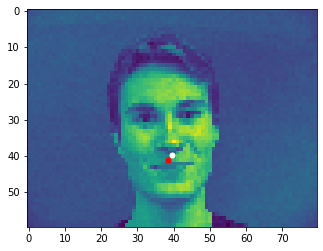

In [23]:
ind = 11
plt.imshow(np.squeeze(predictions[1][ind]))
plt.scatter(predictions[0][ind][0], predictions[0][ind][1], s=100, marker='.', c='r')
plt.scatter(predictions[2][ind].numpy()[0][0][0], predictions[2][ind].numpy()[0][0][1], s=100, marker='.', c='w')

In [222]:
faces = FaceLandmarksDataset('./imm_face_db/', False, Shift())
train_ds, valid_ds = [faces[x] for x in range(192)], [faces[x] for x in range(192, 240)]
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=16)
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True, num_workers=16)

In [223]:
class FaceNet(nn.Module):

    def __init__(self):
        super(FaceNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.conv5 = nn.Conv2d(256, 512, 1)
        self.conv6 = nn.Conv2d(512, 1024, 1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2048, 1024)  # 6*6 from image dimension
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 116)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = F.max_pool2d(F.relu(self.conv5(x)), 2)
        x = F.max_pool2d(F.relu(self.conv6(x)), 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = FaceNet()

In [224]:
model = FaceNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
model = model.to(device)
model = model.double()

In [225]:
train_losses, valid_losses = train(train_dl, valid_dl,
                                   model,criterion, optimizer, fullFace=True,
                                   n_epochs=10,
                                   saved_model='model2.pt')

Epoch: 1 	Training Loss: 35.207647 	Validation Loss: 12.253715
Validation loss decreased (inf --> 12.253715).  Saving model ...
Epoch: 2 	Training Loss: 13.389626 	Validation Loss: 10.963284
Validation loss decreased (12.253715 --> 10.963284).  Saving model ...
Epoch: 3 	Training Loss: 12.621550 	Validation Loss: 9.627586
Validation loss decreased (10.963284 --> 9.627586).  Saving model ...
Epoch: 4 	Training Loss: 12.314911 	Validation Loss: 9.855360
Epoch: 5 	Training Loss: 11.158906 	Validation Loss: 12.890511
Epoch: 6 	Training Loss: 10.632928 	Validation Loss: 9.936610
Epoch: 7 	Training Loss: 10.841432 	Validation Loss: 9.623747
Validation loss decreased (9.627586 --> 9.623747).  Saving model ...
Epoch: 8 	Training Loss: 10.073997 	Validation Loss: 9.393632
Validation loss decreased (9.623747 --> 9.393632).  Saving model ...
Epoch: 9 	Training Loss: 10.885301 	Validation Loss: 10.715012
Epoch: 10 	Training Loss: 10.967106 	Validation Loss: 9.819745


In [226]:
model.load_state_dict(torch.load('model2.pt'))
predictions = predict(valid_dl, model)

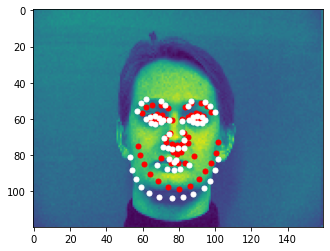

In [228]:
ind = 1
plt.imshow(np.squeeze(predictions[1][ind]))
plt.scatter([x[0] for x in predictions[0][ind].reshape(58,2)], [x[1] for x in predictions[0][ind].reshape(58,2)], s=100, marker='.', c='r')
plt.scatter([x[0] for x in predictions[2][ind].numpy()[0]], [x[1] for x in predictions[2][ind].numpy()[0]], s=100, marker='.', c='w')